# AutoUSD, sUSDe, Aave USDC and BIL (1-3 month T-Bill ETF) Comparison

Task:


> 
> Metrics:
> APY  
> Yield Volatility (annualized)  
> Excess vs 3M T-Bill  
> Information Ratio  
> For products:  
> USD: autoUSD, Ethena sUSDe, Aave USDC lending, US Gov short term treasuries  
> ETH: autoETH, Lido staking (stETH), Aave ETH lending  
> Time periods: 30 day, 1 year, since inception  
> *no 1 year on autoUSD since <1 year old  
> Definitions:  
> Yield Volatility: stdev of monthly net returns × √12  
> Excess vs Benchmark: difference between average net APY and the benchmark (3M T-bill for USD; Lido staking rate for ETH).  
> Information Ratio: average monthly excess return ÷ stdev of monthly excess returns, annualized  


# Methods


## Data sources:

Onchain calls on mainnet at the last block of each day

- autoUSD.converToAssets(1e18) / 1e6 -> USDC value of one autoUSD share
- sUSDe -> chainlink sUSDE -> USD oracle, safe USD value of sUSDe over time.
- Aave USDC lending, stataAaveUSDC.convertToAssets(1e6) / 1e6, growth of a share of the aave USDC vault

BIL `SPDR Bloomberg 1-3 Month T-Bill ETF`

https://www.ssga.com/us/en/intermediary/etfs/spdr-bloomberg-1-3-month-t-bill-etf-bil 

> The SPDR® Bloomberg  1-3 Month T-Bill ETF seeks to provide investment results that, before fees and expenses, correspond generally to the price and yield performance of the Bloomberg  1-3 Month U.S. Treasury Bill Index (the "Index")  
> Seeks to provide exposure to publicly issued U.S. Treasury Bills that have a remaining maturities between 1 and 3 months  
> Short duration fixed income is less exposed to fluctuations in interest rates than longer duration securities  
> Rebalanced on the last business day of the month  


As of Oct 26, 2025 BIL has ~42.5B AUM

```
!pip install yfinance
import yfinance as yf
tickers = ['BIL']
data = yf.download(tickers, start="2024-10-26", end="2025-10-26", actions=True)
data.to_csv('data.csv')

```
## Some Other Notes

- Using linear interpolation between for BIL Closing prices because we don't have prices on the weekends and holidays. 
- BIL Closing price is adjusted for dividends


In [24]:
from multicall import Call

import pandas as pd
import plotly.express as px

from mainnet_launch.data_fetching.get_state_by_block import (
    get_state_by_one_block,
    build_blocks_to_use,
    get_raw_state_by_blocks,
    safe_normalize_6_with_bool_success,
    safe_normalize_with_bool_success,
)
from mainnet_launch.constants import ETH_CHAIN, AUTO_ETH


# https://etherscan.io/address/0x73edDFa87C71ADdC275c2b9890f5c3a8480bC9E6#readProxyContract
# chainlink safe price of sUSDe over time
# https://etherscan.io/address/0x98C23E9d8f34FEFb1B7BD6a91B7FF122F4e16F5c aave USDC
# https://data.chain.link/feeds/ethereum/mainnet/susde-usd


def _process_chainlink_usd_price(success, args):
    """
    Normalize Chainlink latestRoundData -> price as float (answer / 1e6).
    args is: (roundId:uint80, answer:int256, startedAt:uint256, updatedAt:uint256, answeredInRound:uint80)
    """
    round_id, answer, started_at, updated_at, answered_in_round = args
    if success:
        return float(answer) / 1e18


stETH_ETH_chainlink_oracle = '0x86392dC19c0b719886221c78AB11eb8Cf5c52812'

chainlink_stETH_price_call = Call(
    stETH_ETH_chainlink_oracle,
    ["latestRoundData()((uint80,int256,uint256,uint256,uint80))"],
    [("stETH_ETH_safe_price", _process_chainlink_usd_price)],
)

stata_aave = "0xC077F28FC0f10C886253E67Be402A7F7D611D4EE"  # convert to shares calls


aave_convert_to_shares_call = Call(
    stata_aave,
    ["convertToAssets(uint256)(uint256)", int(1e18)],
    [("WETH_aave", safe_normalize_with_bool_success)],
)

autoETH_nav_per_share_call = Call(
    AUTO_ETH.autopool_eth_addr,
    ["convertToAssets(uint256)(uint256)", int(1e18)],
    [("autoETH", safe_normalize_with_bool_success)],
)

wstETH = '0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0'

wstETH_convert_to_shares_call = Call(
    wstETH,
    ["stEthPerToken()(uint256)"],
    [("wstETH", safe_normalize_with_bool_success)],
)

end_of_day_oct_26_2024_block = 21053236

insta_dapp_stETH_looping = '0xA0D3707c569ff8C87FA923d3823eC5D81c98Be78'

ieth_convert_to_assets_call = Call(
    insta_dapp_stETH_looping,
    ["convertToAssets(uint256)(uint256)", int(1e18)],      # 1.0 share → assets
    [("iETH_v2", safe_normalize_with_bool_success)],
)


blocks = build_blocks_to_use(ETH_CHAIN, start_block=end_of_day_oct_26_2024_block)
df = get_raw_state_by_blocks(
    calls=[
        aave_convert_to_shares_call,
        chainlink_stETH_price_call,
        autoETH_nav_per_share_call,
        wstETH_convert_to_shares_call,
        ieth_convert_to_assets_call,
    ],
    blocks=blocks,
    chain=ETH_CHAIN,
)

df['wstETH_eth_price'] = df['wstETH'] * df['stETH_ETH_safe_price']
df['iETH_v2_eth_price'] = df['iETH_v2'] * df['stETH_ETH_safe_price']
df = df[['autoETH', 'WETH_aave', 'wstETH_eth_price', 'iETH_v2_eth_price']]

df


,autoETH,WETH_aave,wstETH_eth_price,iETH_v2_eth_price
timestamp,,,,
2024-10-26 23:59:59+00:00,1.002042,1.033575,1.182742,1.127189
2024-10-27 23:59:59+00:00,1.002097,1.033633,1.182595,1.127002
2024-10-28 23:59:59+00:00,1.002281,1.033691,1.182650,1.127147
2024-10-29 23:59:59+00:00,1.001945,1.033760,1.182739,1.127352
2024-10-30 23:59:59+00:00,1.001997,1.033817,1.182925,1.127635
...,...,...,...,...
2025-10-22 23:59:59+00:00,1.053044,1.054549,1.216398,1.183532
2025-10-23 23:59:59+00:00,1.053105,1.054604,1.216908,1.184003
2025-10-24 23:59:59+00:00,1.053336,1.054660,1.217120,1.184238


In [25]:
px.line(df)

In [28]:
first_non_na_values = df.apply(lambda col: col.loc[col.first_valid_index()])
norm_one_large_df = df / first_non_na_values
# recent_df = df[df.index > pd.to_datetime("2025-04-01").date()]
recent_first_df = df.apply(lambda col: col.loc[col.first_valid_index()])
norm_one_recent_df = df / recent_first_df

import matplotlib.pyplot as plt
px.line(norm_one_recent_df)



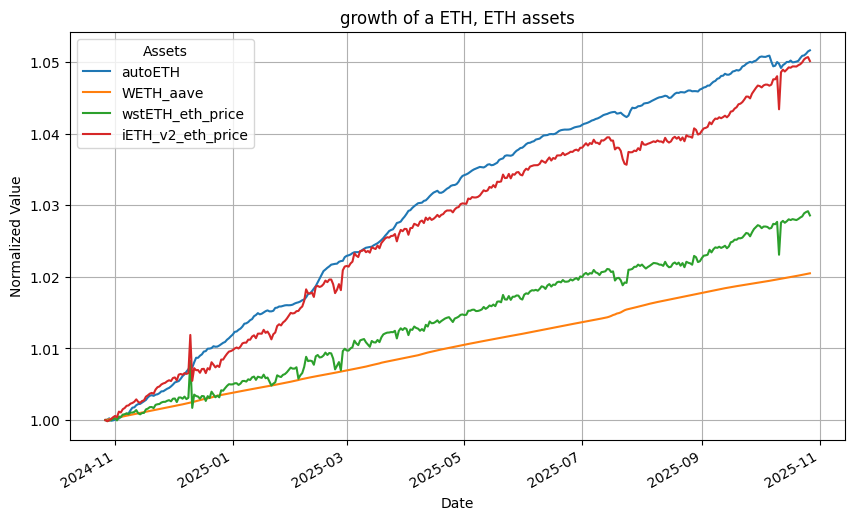

In [29]:
norm_one_recent_df.plot(title='growth of a ETH, ETH assets', figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend(title="Assets")
plt.grid(True)
plt.show()

In [18]:
int(1e18)

1000000000000000000

# APY, Excess APY 30 days and since start

In [30]:
def get_apy_values(norm_one_recent_df: pd.DataFrame):
    start, end = norm_one_recent_df.iloc[0], norm_one_recent_df.iloc[-1]
    days = (norm_one_recent_df.index[-1] - norm_one_recent_df.index[0]).days
    years = days / 365

    all_time_apy = ((end / start) ** (1 / years)) - 1

    start, end = norm_one_recent_df.iloc[-30], norm_one_recent_df.iloc[-1]
    days = (norm_one_recent_df.index[-1] - norm_one_recent_df.index[-30]).days
    years = days / 365

    month_apy = ((end / start) ** (1 / years)) - 1

    return 100 * all_time_apy, 100 * month_apy


def determine_excess_vs_bench_mark(apy_df, bench_mark_column: str):
    results = {}
    for col in apy_df.index:
        if col != bench_mark_column:
            excess_apy = apy_df[col] - apy_df[bench_mark_column]
            results[col] = excess_apy
    return pd.Series(results)


stable_coins_all_time_apy, stable_coins_30_day_apy = get_apy_values(norm_one_recent_df)

vs_benchmark_all_time = determine_excess_vs_bench_mark(stable_coins_all_time_apy, "wstETH_eth_price")
vs_benchmark_30_day = determine_excess_vs_bench_mark(stable_coins_30_day_apy, "wstETH_eth_price")
print(f"Excess vs Benchmark (All Time):\n{vs_benchmark_all_time}\n")
print(f"Excess vs Benchmark (30 Day):\n{vs_benchmark_30_day}\n")

Excess vs Benchmark (All Time):
autoETH              2.307152
WETH_aave           -0.808851
iETH_v2_eth_price    2.157087
dtype: float64

Excess vs Benchmark (30 Day):
autoETH             -0.509143
WETH_aave           -0.617772
iETH_v2_eth_price    2.755263
dtype: float64



# Yield Volatility

In [31]:
# Yield Volatility: stdev of monthly net returns × √12

import pandas as pd, numpy as np


def annualized_vol_monthly(monthly_returns: pd.Series) -> float:
    return monthly_returns.std(ddof=1) * np.sqrt(12)


norm_one_recent_df.index = pd.to_datetime(norm_one_recent_df.index)
end_of_month_values = norm_one_recent_df.resample("ME").last()
monthly_growth_annualized = (((end_of_month_values / end_of_month_values.shift(1)) ** 12) - 1) * 100
yield_volatility = monthly_growth_annualized.std(ddof=1) * np.sqrt(12)
yield_volatility

autoETH              7.998433
WETH_aave            1.100605
wstETH_eth_price     3.796501
iETH_v2_eth_price    7.459452
dtype: float64

# Information Ratio

In [ ]:
# Information Ratio: average monthly excess return ÷ stdev of monthly excess returns, annualized
# how can I tell how much they are looping?
excess_return = monthly_growth_annualized.sub(monthly_growth_annualized["wstETH_eth_price"], axis=0)
average_monthly_excess_return = excess_return.mean()
std_monthly_excess_return = excess_return.std(ddof=1)
information_ratio = average_monthly_excess_return / std_monthly_excess_return
information_ratio

autoETH              1.095449
WETH_aave           -0.660231
wstETH_eth_price          NaN
iETH_v2_eth_price    1.379924
dtype: float64